In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from heapq import nsmallest
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, ifft
from scipy import integrate

### Lecture Data

In [2]:
theoric_lines = pd.read_csv('DataSet/Inputs/theoric_c_lines.txt', delimiter = '\t', header = 0)
theoric_lines['wave_peak'] = theoric_lines['wave_peak']/10
theoric_lines['wave_base'] = theoric_lines['wave_base']/10
theoric_lines['wave_top'] = theoric_lines['wave_top']/10

c_s = pd.read_csv('DataSet/Inputs/Subtracted_spectrum.txt', delimiter = '\t', header = 0)

data_klaus = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)

growth_c_ispec_gauss = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_gauss.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)
growth_c_ispec_voigth = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_voigth.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)

#growth_c_mine = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve.dat", delimiter = '\t', header = 0)
Atomic_lines = pd.read_csv('DataSet/Inputs/atomic_lines.tsv', delimiter = '\t', usecols = ['element', 'wave_nm', 'loggf', 'lower_state_eV', 'upper_state_eV'],   header = 0, low_memory=False, keep_default_na= False)
Atomic_lines = Atomic_lines[(Atomic_lines['wave_nm']>=375) & (Atomic_lines['wave_nm']<=465)]

In [57]:
data_klausFe1 = pd.read_csv("DataSet/Inputs/Fe1_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1', 'ewr2'], header = 0)
data_klausTi2 = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1', 'ewr2'], header = 0)

dataFe1_24oct = pd.read_csv("DataSet/Outputs/Fe 1_growth_curve_24oct.dat", delimiter = '\t', header = 0)
dataTi2_24oct = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve_24oct.dat", delimiter = '\t', header = 0)

dataFe1_25oct = pd.read_csv("DataSet/Outputs/Fe 1_growth_curve_25oct.dat", delimiter = '\t', header = 0)
dataTi2_25oct = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve.dat", delimiter = '\t', header = 0)

## Found absortion lines

In [77]:
top = []
for i in range(len(theoric_lines['wave_top'])):
    top.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_top'][i]))[0])

In [78]:
base = []
for i in range(len(theoric_lines['wave_base'])):
    base.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_base'][i]))[0])

In [81]:
#Create new list with contain the absortion lines in cromospheric spectrum with its respective element
c_lines_spectrum = pd.DataFrame(columns = ['wave_peak', 'wave_base', 'wave_top','note', 'flux', 'error_f'])
L = []
I = []
mins = []
       
for i in range(len(base)):
    b = c_s['waveobs']>base[i]
    a = c_s['waveobs']<top[i]
    c = a&b 
    min_ = min(c_s['flux'][c])
    L.append(c_s["waveobs"][c][c_s["flux"][c] == min_].tolist()[0])
    I.append(c_s['flux'][c][c_s["flux"][c] == min_].tolist()[0])
    mins.append(min_)
    
c_lines_spectrum['wave_peak'] = L
c_lines_spectrum['wave_base'] = base
c_lines_spectrum['wave_top'] = top
c_lines_spectrum['note'] = theoric_lines['note']
c_lines_spectrum['flux'] = I
c_lines_spectrum['error_f'] = c_s['err']

In [83]:
c_lines_spectrum.to_csv("c_lines_spectrum.txt", sep='\t', index = False, header=True)

## Test Equivalent Width

#### Fit

In [107]:
#Number of splines
def step_continuum(Lmin,Lmax,splines):
    return (Lmax-Lmin)/splines

#New dots to found continuous
def Points_continuum(_lambda, Intensity,start,end,step):
    
    steps_list = np.arange(start,end, step)
    grouped_data = {}
    grouped_data['L'] = []
    grouped_data['I'] = []
    for i in range(1,len(steps_list)):
        grouped_lambda = _lambda[(_lambda >= steps_list[i-1]) & (_lambda < steps_list[i])]

        grouped_data['L'].append(grouped_lambda)
        grouped_data['I'].append(Intensity[  grouped_lambda.index  ])
    return grouped_data

#Fit contunuous to line data
def fit_continuum(grouped_data, L_min, L_max):  
    newdataL = [] 
    newdataI = []
    for i in range(len(grouped_data['I'])):
        newdataL.append(grouped_data['L'][i].median())
        newdataI.append(grouped_data['I'][i].median())
        data_fitL = [x for x in newdataL if str(x) != 'nan']
        data_fitI = [x for x in newdataI if str(x) != 'nan']
    cs = InterpolatedUnivariateSpline(data_fitL,data_fitI)
    xs =  np.linspace(L_min,  L_max, 100)
    fit =  pd.DataFrame({'L': xs, 'I': cs(xs)})
    return fit

In [135]:
step = step_continuum(Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],20)

grouped_data = Points_continuum(c_s['waveobs'], c_s['flux'],Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],step)

fit1 = fit_continuum(grouped_data, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0]+0.07)
fit = fit1[(fit1['L'] >= Ti2_gf['wave_base'][0]) & (fit1['L'] <= Ti2_gf['wave_top'][0])]


,L,I
0,376.075000,1.273505
1,376.077071,1.229357
2,376.079141,1.176255
3,376.081212,1.115694
4,376.083283,1.049175
...,...,...
61,376.201313,0.951128
62,376.203384,0.875268
63,376.205455,0.754169
64,376.207525,0.582042


#### Pseudocontinuou

In [120]:
def pseudocontinuou(Data,LMIN, LMAX):
    pseudo_continuous1 = c_s[(c_s['waveobs'] <= LMIN)  & (c_s['waveobs'] > (LMIN-0.05))]
    pseudo_continuous2 = c_s[(c_s['waveobs'] >= LMAX )  & (c_s['waveobs'] < (LMAX+0.05))]
    pseudo_continuous1.index = list(range(len(pseudo_continuous1)))
    pseudo_continuous2.index = list(range(len(pseudo_continuous2)))

    mean1 = np.mean(pseudo_continuous1)
    mean2 = np.mean(pseudo_continuous2)
    mean = (mean1['flux'] + mean2['flux'])/2
    return mean

In [121]:
mean = pseudocontinuou(c_s, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0])

## Graph

### Equivalent width

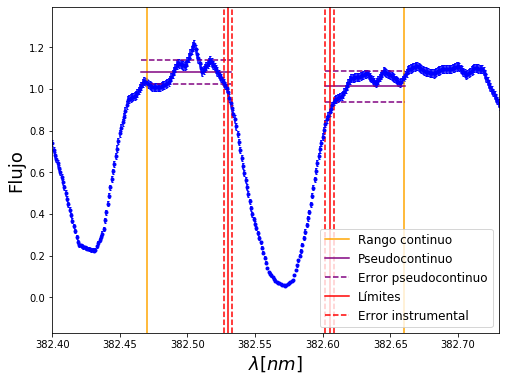

In [11]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.plot(c_s['waveobs'][7590],c_s['flux'][7590], color = 'red',marker='o', ls='', label = 'mins')

plt.xlim(382.4,382.73)

plt.axvline(382.47, color = 'orange', label ='Rango continuo')
plt.axhline(c_s['flux'][7490:7551].mean(), color = 'purple', xmin=0.2, xmax=0.4, label ='Pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'purple', xmin=0.2, xmax=0.4, label ='Error pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'purple', xmin=0.2, xmax=0.4 )


plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.66, color = 'orange')

plt.axhline(c_s['flux'][7620:7680].mean(), color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() + c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() - c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)

plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta')


#plt.ylim(-2.5, 3)
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


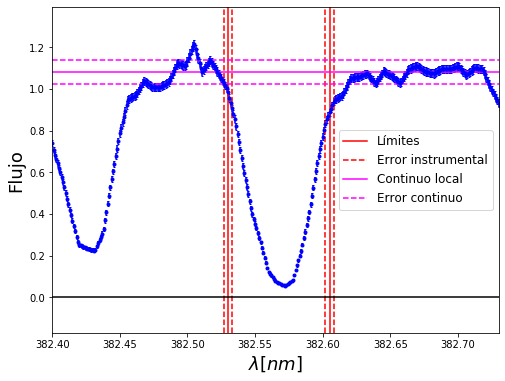

In [8]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    

plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta', label='Continuo local')
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 + (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta', label = 'Error de Continuo' )
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 - (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta')

plt.axhline(c_s['flux'][7490:7551].mean(), color = 'magenta', label='Continuo local')
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'magenta', label ='Error continuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'magenta' )

plt.axhline(0, color = 'black')

#plt.ylim(-2.5, 3)
plt.xlim(382.4,382.73)
#plt.grid()
#plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

# CURVAS DE CRECIMIENTO

## Ti ll

### Experimental

In [147]:
dataTi2_24oct  = dataTi2_24oct[~dataTi2_24oct.index.isin([0,1,8,13])]
dataTi2_24oct.index = list(range(len(dataTi2_24oct)))

In [148]:
dataTi2_24oct

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,error_f,errEWR
0,390.063767,389.996654,390.106476,Ti 2,0.129236,-0.29,1.131,4.308,0.049013,-3.900827,0.007739,0.016607
1,391.351118,391.296207,391.399927,Ti 2,0.207386,-0.36,1.116,4.283,0.039436,-3.996678,0.006613,0.019102
2,393.205878,393.187575,393.218081,Ti 2,0.564217,-1.59,1.131,4.283,0.013836,-4.453613,0.006819,0.055756
3,430.008236,429.977730,430.044843,Ti 2,0.178665,-0.46,1.180,4.063,0.030766,-4.145413,0.006851,0.005036
4,439.507784,439.446772,439.550492,Ti 2,0.127288,-0.54,1.084,3.904,0.045070,-3.989078,0.007419,0.007147
5,444.388733,444.339923,444.437542,Ti 2,0.144923,-0.71,1.080,3.869,0.033833,-4.118417,0.006948,0.000791
6,450.129950,450.093342,450.172658,Ti 2,0.120890,-0.77,1.116,3.869,0.027581,-4.212729,0.126655,0.069920
7,454.955988,454.901078,455.010899,Ti 2,0.088935,-0.22,1.584,4.308,0.048464,-3.972547,0.120326,0.022999
8,456.359261,456.334856,456.420273,Ti 2,0.149394,-0.69,1.221,3.937,0.022006,-4.316760,0.078231,0.045424
9,457.207326,457.146314,457.250034,Ti 2,0.131799,-0.31,1.572,4.283,0.030167,-4.180579,0.006684,0.036572


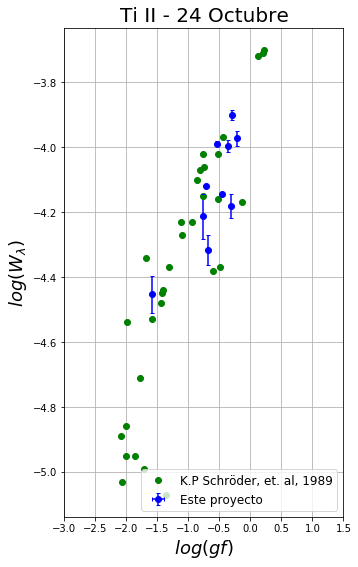

In [149]:
plt.figure(figsize = [5,9])

plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataTi2_24oct['loggf'],dataTi2_24oct['EWR'],dataTi2_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)
    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 24 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [55]:
dataTi2_25oct

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,error_f,errEWR
0,375.915115,375.878508,376.006633,Ti 2,-0.022298,0.28,0.607,3.904,NaN,NaN,0.007090,NaN
1,376.116455,376.049342,376.183568,Ti 2,-0.036926,0.18,0.574,3.869,0.090394,-3.619181,0.007743,0.070765
2,378.636245,378.624042,378.666751,Ti 2,0.481329,-2.60,0.607,3.881,0.017658,-4.331281,0.007739,0.052369
3,381.461094,381.381779,381.467195,Ti 2,0.222786,-1.68,0.574,3.823,0.004212,-4.956929,0.006613,0.363322
4,388.233411,388.184602,388.239512,Ti 2,0.480805,-1.87,1.116,4.308,0.013732,-4.451358,0.006819,0.119903
5,391.357219,391.284005,391.381624,Ti 2,0.029227,-0.36,1.116,4.283,0.057148,-3.835570,0.006851,0.065061
6,398.776262,398.727452,398.794565,Ti 2,0.501318,-2.73,0.607,3.716,0.016774,-4.376086,0.007419,0.040591
7,401.247242,401.180129,401.259445,Ti 2,0.151288,-1.78,0.574,3.663,0.030756,-4.115475,0.006948,0.104205
8,402.845753,402.778640,402.857956,Ti 2,0.392731,-0.92,1.892,4.969,0.018658,-4.334282,0.007209,0.059433
9,416.158542,416.085328,416.164644,Ti 2,0.464828,-2.09,1.084,4.063,0.016613,-4.398821,0.126655,0.060110


In [93]:
dataTi2_25oct  = dataTi2_25oct[~dataTi2_25oct.index.isin([0,2,6,8,19])]
dataTi2_25oct  = dataTi2_25oct[~dataTi2_25oct.index.isin([0,2,6,8,19])]

dataTi2_25oct.index = list(range(len(dataTi2_25oct)))

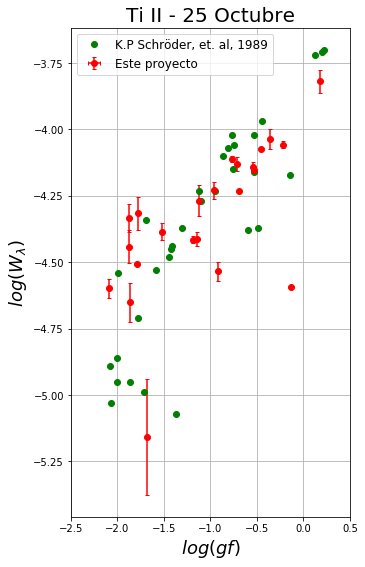

In [61]:
plt.figure(figsize = [5,9])
#plt.plot(-1.68,-4.956929,marker='o', ls='', color = 'red', label = 'prueba')
plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataTi2_25oct['loggf'],dataTi2_25oct['EWR']-0.2,dataTi2_25oct['errEWR']*0.6, 0, color = 'red', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)


    
plt.xlim(-2.5,0.5)
#plt.ylim(-5, -3)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II - 25 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

### Teórica

In [151]:
def Growth_theoric(gf,_lambda,E_i,T_exc):
    return gf*_lambda*np.exp(-E_i/T_exc)/(27.0)


theo_Ti2_24oct = []
for i in range(0,len(dataTi2_24oct['loggf'])):
    theo_Ti2_24oct.append(Growth_theoric(10**(dataTi2_24oct['loggf'][i]), dataTi2_24oct['wave_peak'][i], (dataTi2_24oct['upper_state_eV'][i] - dataTi2_24oct['lower_state_eV'][i] ), 5000))

def ajuste_teo_exp(x,N,a):
    return np.log10(x*N) + a
ajus, ajus1 = scipy.optimize.curve_fit(ajuste_teo_exp, np.array(theo_Ti2_24oct), dataTi2_24oct['loggf'])

theoric_newTi2_24oct = np.log10(np.array(theo_Ti2_24oct)*ajus[0]) + ajus[1]
print(ajus[1])
def ajuste(x,a,b):
    return a*x + b

popt1, pcov1 = scipy.optimize.curve_fit(ajuste, theoric_newTi2_24oct, dataTi2_24oct['EWR'])

xfit_Ti2_24 = np.linspace(min(theoric_newTi2_24oct), max(theoric_newTi2_24oct), 100)
yfit_Ti2_24 = ajuste(xfit_Ti2_24,*popt1)

0.23879608593566878


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


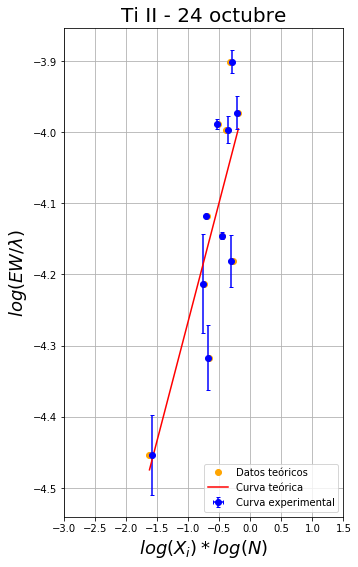

In [155]:
plt.figure(figsize = [5,9])

plt.plot(theoric_newTi2_24oct, dataTi2_24oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')
plt.plot(xfit_Ti2_24,yfit_Ti2_24,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar((dataTi2_24oct['loggf']),dataTi2_24oct['EWR'],dataTi2_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)

plt.xlim(-3,1.5)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti II - 24 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i)*log(N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [156]:
theo_Ti2_25oct = []
for i in range(0,len(dataTi2_25oct['loggf'])):
    theo_Ti2_25oct.append(Growth_theoric(10**(dataTi2_25oct['loggf'][i]), dataTi2_25oct['wave_peak'][i], (dataTi2_25oct['upper_state_eV'][i] - dataTi2_25oct['lower_state_eV'][i] ), 5000))

ajus2, ajus3 = scipy.optimize.curve_fit(ajuste_teo_exp, np.array(theo_Ti2_25oct), dataTi2_25oct['loggf'])

print(ajus2)
theoric_newTi2_25oct = np.log10(np.array(theo_Ti2_25oct)*ajus2[0]) + ajus2[1]
popt, pcov = scipy.optimize.curve_fit(ajuste, theoric_newTi2_25oct, dataTi2_25oct['EWR'])

xfit_Ti2_25 = np.linspace(min(theoric_newTi2_25oct), max(theoric_newTi2_25oct), 100)
yfit_Ti2_25 = ajuste(xfit_Ti2_25,*popt)

[ 0.16504051 -0.4141977 ]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


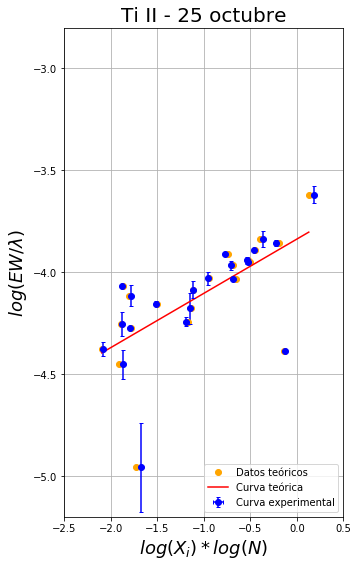

In [158]:
plt.figure(figsize = [5,9])

#plt.plot(np.log10(np.array(theo_Ti2_25oct)*0.16504051) -0.4141977, dataTi2_25oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')
plt.plot(theoric_newTi2_25oct, dataTi2_25oct['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')

plt.plot(xfit_Ti2_25,yfit_Ti2_25,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar(dataTi2_25oct['loggf'],dataTi2_25oct['EWR'],dataTi2_25oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

#*2.32 + 2.79
for cap in caps:
    cap.set_markeredgewidth(1)

plt.xlim(-2.5,0.5)
plt.ylim(-5.2, -2.8)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti II - 25 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i)*log(N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

## Fe l

### Experimentales

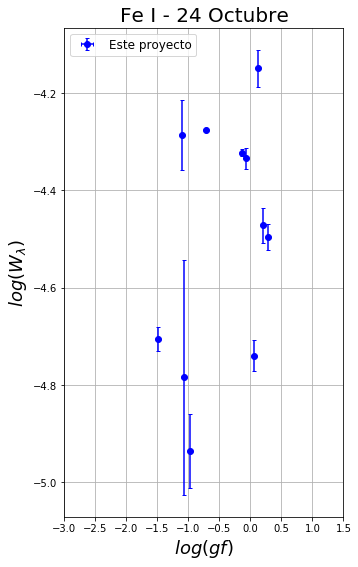

In [22]:
plt.figure(figsize = [5,9])

#plt.plot(data_klausFe1['loggf'],data_klausFe1['ewr2'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataFe1_24oct['loggf'],dataFe1_24oct['EWR'],dataFe1_24oct['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)

    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Fe I - 24 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [19]:
dataFe1_25oct

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,error_f,errEWR
0,376.384843,376.317729,376.409248,Fe 1,0.094054,-0.238,0.990,4.283,0.040795,-3.965028,0.046581,0.082469
1,376.726512,376.659398,376.732613,Fe 1,0.112314,-0.389,1.011,4.301,0.026395,-4.154502,0.052777,0.234446
2,378.794830,378.733818,378.800931,Fe 1,0.311538,-0.859,1.011,4.283,0.014681,-4.411658,0.043207,0.206572
3,379.508675,379.447662,379.514776,Fe 1,0.159511,-0.761,0.990,4.256,0.018675,-4.307961,0.036002,0.242680
4,379.966267,379.911356,379.996773,Fe 1,0.129010,-0.846,0.958,4.220,0.031663,-4.079198,0.020448,0.209043
5,381.595297,381.522082,381.613600,Fe 1,0.176425,0.237,1.485,4.733,0.036359,-4.020995,0.050002,0.118387
6,382.052889,381.973573,382.083396,Fe 1,0.072161,0.119,0.859,4.103,0.061854,-3.790758,0.044203,0.023396
7,382.455571,382.388457,382.467773,Fe 1,0.207214,-1.362,0.000,3.241,0.036602,-4.019082,0.043790,0.116467
8,382.595899,382.516583,382.644709,Fe 1,0.082459,-0.037,0.915,4.154,0.049344,-3.889509,0.051672,0.085688
9,382.791139,382.717924,382.797240,Fe 1,0.207568,0.062,1.557,4.796,0.024615,-4.191757,0.057981,0.171143


In [136]:
dataFe1_25oct  = dataFe1_25oct[~dataFe1_25oct.index.isin([4,11])]
dataFe1_25oct.index = list(range(len(dataFe1_25oct)))

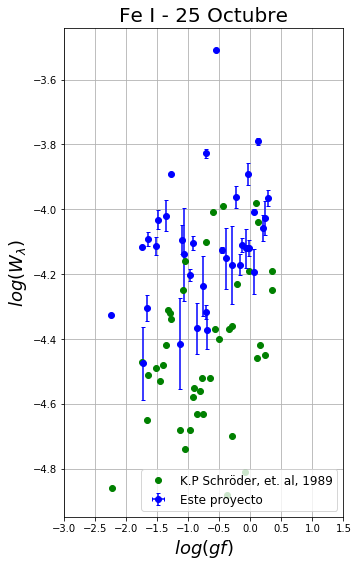

In [137]:
plt.figure(figsize = [5,9])

plt.plot(data_klausFe1['loggf'],data_klausFe1['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(dataFe1_25oct['loggf'],dataFe1_25oct['EWR'],dataFe1_25oct['errEWR']*0.4, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')

for cap in caps:
    cap.set_markeredgewidth(1)

    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Fe I - 25 Octubre',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

### Teóricas

In [25]:
theo_Fe1_24oct = []
for i in range(0,len(dataFe1_24oct['loggf'])):
    theo_Fe1_24oct.append(Growth_theoric(10**(dataFe1_24oct['loggf'][i]), dataFe1_24oct['wave_peak'][i], (dataFe1_24oct['upper_state_eV'][i] - dataFe1_24oct['lower_state_eV'][i] ), 5000))

popt4, pcov4 = scipy.optimize.curve_fit(ajuste, np.log(theo_Fe1_24oct), dataFe1_24oct['EWR'])

xfit_Fe1_24= np.linspace(min(np.log(theo_Fe1_24oct)), max(np.log(theo_Fe1_24oct)), 100)
yfit_Fe1_24 = ajuste(xfit_Fe1_24,*popt4)

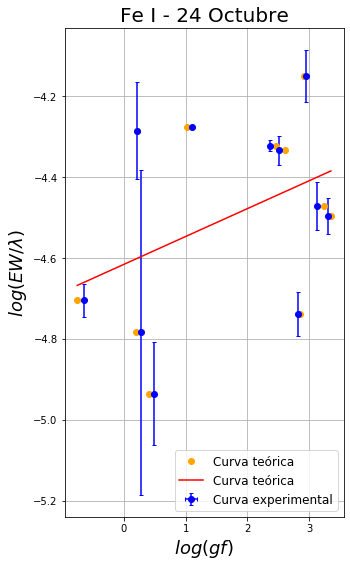

In [26]:
plt.figure(figsize = [5,9])

plt.plot(np.log(theo_Fe1_24oct),dataFe1_24oct['EWR'],marker='o', ls='', color = 'orange', label = 'Curva teórica')
plt.plot(xfit_Fe1_24,yfit_Fe1_24,marker='', ls='-', color = 'red', label = 'Curva teórica')

(_, caps, _) = plt.errorbar((dataFe1_24oct['loggf']*2.23 +2.68),dataFe1_24oct['EWR'],dataFe1_24oct['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.xlim(-20,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Fe I - 24 Octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.xscale('log')

plt.legend(fontsize = 12)
plt.show()

In [143]:
theo_Fe1_25oct = []
for i in range(0,len(dataFe1_25oct['loggf'])):
    theo_Fe1_25oct.append(Growth_theoric(10**(dataFe1_25oct['loggf'][i]), dataFe1_25oct['wave_peak'][i], (dataFe1_25oct['upper_state_eV'][i] - dataFe1_25oct['lower_state_eV'][i] ), 5000))

ajus4, ajus5 = scipy.optimize.curve_fit(ajuste_teo_exp, np.array(theo_Fe1_25oct), dataFe1_25oct['loggf'])

theoric_newFe1_25oct = np.log10(np.array(theo_Fe1_25oct)*ajus4[0]) + ajus4[1]
popt, pcov = scipy.optimize.curve_fit(ajuste, theoric_newFe1_25oct, dataFe1_25oct['EWR'])

xfit_Fe1_25 = np.linspace(min(theoric_newFe1_25oct), max(theoric_newFe1_25oct), 100)
yfit_Fe1_25 = ajuste(xfit_Fe1_25,*popt)

[ 8.05345821  5.69346592  1.93979631  2.43542246 24.37570347 18.59850246
  0.61508585 13.00454699 16.34243595  7.0800547   0.26297856  0.73883332
  2.78572471  1.49131584  1.69183391  1.20754235  1.0327402   4.07608491
  0.30827966  4.9403854   0.08263193  0.26042689  0.32432215  0.43704925
  0.4696708  28.53553294 17.34957101 14.32722953  3.04681515  3.03989305
 10.83923235  1.23385524 13.47898536 25.71711641 11.75768787]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log10
  # Remove the CWD from sys.path while we load stuff.


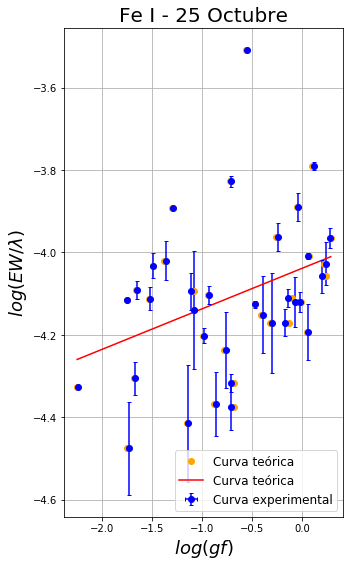

In [144]:
plt.figure(figsize = [5,9])

plt.plot(theoric_newFe1_25oct,dataFe1_25oct['EWR'],marker='o', ls='', color = 'orange', label = 'Curva teórica')
plt.plot(xfit_Fe1_25,yfit_Fe1_25,marker='', ls='-', color = 'red', label = 'Curva teórica')

(_, caps, _) = plt.errorbar(dataFe1_25oct['loggf'],dataFe1_25oct['EWR'],dataFe1_25oct['errEWR']*0.4, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.xlim(-20,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Fe I - 25 Octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.xscale('log')

plt.legend(fontsize = 12)
plt.show()

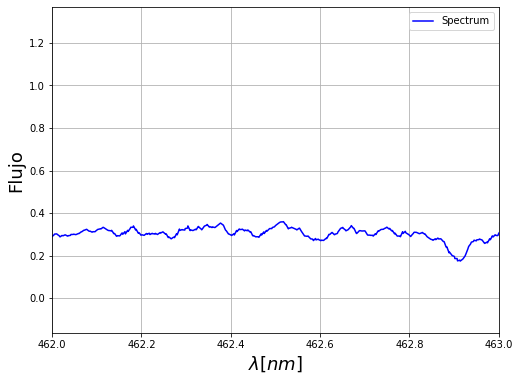

In [662]:
plt.figure(figsize = [8,6])

plt.plot(c_s['waveobs'],c_s['flux'],color = 'blue', marker='',ls = '-',label = 'Spectrum')


plt.axvline(458.31, color = 'red')
plt.axvline(458.416, color = 'red')

plt.xlim(462, 463)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [3]:
b = c_s['waveobs']>376.075
a = c_s['waveobs']<376.210
c = a&b
errorA2 = np.sqrt(np.sum(c_s['err'][c]**2))

In [4]:
errorA2

0.20710838958897468

In [26]:
1.2*(0.05/1.2)*((0.03 + 0.03)/(0.1))

0.03

In [12]:
np.sqrt(np.sum(c_s['err'][c]**2))

0.20710838958897468